In [1]:
%pylab inline             
import os
import aplpy
import string
import sys
import dtdutils
reload(dtdutils)
from astropy import units as u
from astropy.wcs import WCS 
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.io import ascii 
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
from astropy import coordinates as coordf
from astropy.time import Time
from matplotlib.patches import Rectangle

from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

Populating the interactive namespace from numpy and matplotlib


In [2]:
print rcParams.keys()
#Path definitions
DTDpath = os.getenv('DTD')+'/'
Plotpath = DTDpath + 'Writeup/Sarba17_DTDRRLyrae_AASTex/'

[u'_internal.classic_mode', u'agg.path.chunksize', u'animation.avconv_args', u'animation.avconv_path', u'animation.bitrate', u'animation.codec', u'animation.convert_args', u'animation.convert_path', u'animation.ffmpeg_args', u'animation.ffmpeg_path', u'animation.frame_format', u'animation.html', u'animation.mencoder_args', u'animation.mencoder_path', u'animation.writer', u'axes.autolimit_mode', u'axes.axisbelow', u'axes.edgecolor', u'axes.facecolor', u'axes.formatter.limits', u'axes.formatter.offset_threshold', u'axes.formatter.use_locale', u'axes.formatter.use_mathtext', u'axes.formatter.useoffset', u'axes.grid', u'axes.grid.axis', u'axes.grid.which', u'axes.hold', u'axes.labelcolor', u'axes.labelpad', u'axes.labelsize', u'axes.labelweight', u'axes.linewidth', u'axes.prop_cycle', u'axes.spines.bottom', u'axes.spines.left', u'axes.spines.right', u'axes.spines.top', u'axes.titlepad', u'axes.titlesize', u'axes.titleweight', u'axes.unicode_minus', u'axes.xmargin', u'axes.ymargin', u'axes3

In [3]:
ogle3fields = ascii.read(DTDpath+'RRLyrae_OGLE/OGLEIII_Fields.txt')

In [4]:
if True:
    fileName = DTDpath + 'InputFiles/OGLE_LMC_RRLyrae_noOutliers.txt'
    firstLine = 7
    lastLine = 24913
    objClassName = 'RRLyrae'
    refName = 'OGLE'
    
obj_subtype = 'All'
objListRA, objListDec = dtdutils.object_ra_decs(fileName, objClassName, obj_subtype=obj_subtype)

#Read SFH map

sfhFileName = DTDpath + 'MC_SFH_Maps/lmc_sfh.dat'
outPathName = DTDpath + 'Output_SFH_Files/'
print 'Reading SFH from file '+sfhFileName
nCells = 0
nAgeBins = 16
cellNames = []
cellCentersRA = []
cellCentersDec = []
sfhMap = []
with open(sfhFileName, 'r') as f:
    for i in range(17): f.readline()
    while True:
        line = f.readline() #Hyphens
        if not line : 
            print 'End of file reached after cell ', nCells
            break #Check EOF
        
        words = f.readline().split()
        cellNames.append(words[1])  #Cell name    
        #print 'Reading cell ' + cellNames[-1]
        words = f.readline().split() #Cell center
        cellCentersRA.append(float(words[1][0:2]) + float(words[2][0:2])/60.0)
        cellCentersDec.append(float(words[3][0:3]) - float(words[4][0:2])/60.0)
        line = f.readline() #Hyphens
        sfhCell = np.zeros([3,nAgeBins])
        for bin in range(nAgeBins) :
            floats = [float(x) for x in f.readline().split()]
            floatArr = np.asarray(floats)
            sfhCell[0,nAgeBins-1-bin] = floatArr[[1,4,7,10]].sum() #Best Fit
            sfhCell[1,nAgeBins-1-bin] = floatArr[[2,5,8,11]].sum() #Lower limit
            sfhCell[2,nAgeBins-1-bin] = floatArr[[3,6,9,12]].sum() #Upper limit
            f.readline() #Blank line

        sfhMap.append(sfhCell)
        nCells += 1

sfhMapArr = np.asarray(sfhMap)
sfhMapArr = sfhMapArr/1e6 #Appears to be SFH for 'x' number of cells, 3 columns (median, upper, lower)limit and in different agebins        
cellCentersRA = np.asarray(cellCentersRA)
cellCentersDec = np.asarray(cellCentersDec)

#Modified cell centers: read from file
cellCentersFileName = DTDpath + 'MC_SFH_Maps/LMC_SFH_Cell_Centers_Corrected.txt'
undivCells = [item for item in range(nCells) if len(cellNames[item]) == 2]
divCells = [item for item in range(nCells) if len(cellNames[item]) == 5]
nColumns = 24
nRows = 19
with open(cellCentersFileName, 'r') as f:
    for cell in range(nCells) :
        words = f.readline().split()
        cellIndex = cellNames.index(words[0])
        cellCentersRA[cellIndex] = float(words[1])
        cellCentersDec[cellIndex] = float(words[2])
        ## if len(words[0]) == 2 :
        ##     verticesRA = cellCentersRA[cellIndex] + 0.5*raInc*np.array([-1,-1,1,1]) 
        ##     verticesDec = cellCentersDec[cellIndex] + 0.5*decInc*np.array([-1,1,1,-1]) 
            #fig.show_rectangles(cellCentersRA[cellIndex],cellCentersDec[cellIndex],raInc,decInc,color='blue')
            # else :
            # fig.show_rectangles(cellCentersRA[cellIndex],cellCentersDec[cellIndex],0.5*raInc,0.5*decInc,color='blue')
        # print cellNames[cellIndex]


#~~~~~~~~~~~ Not sure what this part of the code is doing~~~~~~~~~~~~~~~~~~~#
raInc = cellCentersRA[3]-cellCentersRA[0] #BA-AA
decInc = cellCentersDec[1]-cellCentersDec[0] #AB-AA
raOrigin = 5.5-13.0*raInc
decOrigin = -72-0.75*decInc
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
#Write file with number of objects in each cell that falls within the survey area
if refName == 'OGLE' : 
    surveyCells = [line.strip() for line in open(DTDpath + 'MC_SFH_Maps/LMC_SFH_Cells_OGLE.txt')]
elif refName == 'Reid&Parker' :
    surveyCells = [line.strip() for line in open(DTDpath + 'MC_SFH_Maps/LMC_SFH_Cells_Reid&Parker.txt')]
#    surveyCells = cellsinSFHSurvey(cellNames, cellCentersRA, cellCentersDec)
else : 
    surveyCells = cellNames
    
nSurveyCells = len(surveyCells)
objRAArr = 15.0*np.asarray(objListRA)
objDecArr = np.asarray(objListDec)
cellInSurvey = np.zeros(nCells,dtype='bool')
nObjAcc = 0
objMap = np.zeros(nCells)
for cell in range(nCells) :
    #Determine if cell is within survey area
    if cellNames[cell] in surveyCells :
        cellInSurvey[cell] = True
        if len(cellNames[cell]) == 2 :
            cellHalfSizeRA = raInc/2.0
            cellHalfSizeDec = decInc/2.0
        else :
            cellHalfSizeRA = raInc/4.0
            cellHalfSizeDec = decInc/4.0
            
        objInCell = np.logical_and(abs(objRAArr - cellCentersRA[cell]) <= cellHalfSizeRA, 
                                   abs(objDecArr - cellCentersDec[cell]) <= cellHalfSizeDec)
        
        nObjInCell = objInCell.sum()
        nObjAcc += nObjInCell
        objMap[cell] = nObjInCell
            
print 'HZ cells in survey area: ', cellInSurvey.sum()
print 'Total objects: ', nObjAcc, objMap.sum()
###================================================##
### <><><><><><> FITS Table approach <><><><><><><>##
###================================================##

line_list = [np.array([[cellCentersRA[0], cellCentersRA[-1]], [cellCentersDec[0], cellCentersDec[0]]])]


#Bin SFH map and write final file
logAgeArr = np.asarray([6.8, 7.1, 7.4, 7.7, 8.0, 8.2, 8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2])
ageArr = 10.0**logAgeArr
logAgeLimsArr = np.asarray([6.65,6.95,7.25,7.55,7.85,8.1,8.3,8.5,8.7,8.9,9.1,9.3,9.5,9.7,9.9,10.1,10.3])
ageLimsArr = 10.0**logAgeLimsArr
ageIntervalsArr = ageLimsArr[1:]-ageLimsArr[:-1]
#ageIntervalsArr = np.asarray([4101224.2, 9404646.0, 18764724., 37440568., 54185272., 75594208.,
#                              1.1980914e+08, 1.8988461e+08, 3.0094621e+08, 4.7696742e+08, 7.5594214e+08, 
#                              1.1980915e+09, 1.8988457e+09, 3.0094623e+09, 4.7696753e+09, 5.9120108e+09])

binningSchemeNames = ['Coarse','Massive','Medium','MediumB','MediumC','Subfine','Fine','CrazyCeph','RRLyraeLB','Unbinned']
nSchemes = len(binningSchemeNames)
#binsList = [[0, 1, 2], [3, 4, 5, 6, 7, 8], [9, 10], [11, 12], [13], [14, 15]] 
binningSchemes = [[[0,1,2,3],[4,5,6,7,8],[9,10,11,12,13,14,15]]
                  ,[[0],[1],[2],[3,4,5,6,7,8,9,10,11,12,13,14,15]]
                  ,[[0,1,2],[3,4,5,6,7,8],[9,10],[11],[12,13],[14,15]]
                  ,[[0,1,2],[3,4,5,6,7,8],[9,10],[11,12],[13],[14,15]]
                  ,[[0,1,2],[3,4,5,6],[7,8,9,10],[11,12],[13],[14,15]]
                  ,[[0,1,2],[3,4,5],[6,7,8],[9,10],[11,12],[13],[14,15]]
                  ,[[0,1,2],[3,4,5],[6,7,8],[9,10],[11],[12],[13],[14,15]]
                  ,[[0],[1],[2,3],[4],[5,6,7],[8,9],[10,11,12], [13,14,15]]
                  ,[[0,1,2,3,4,5,6,7,8,9],[10],[11],[12],[13,14],[15]]
                  ,range(16)]


corrList = []
corrListNorm = []
sfhMapBinnedList = []
sfhMapTotal = np.reshape(np.dot(sfhMapArr[:,0,:],ageIntervalsArr),nCells)

print '\n\nCreating SFH files ending in .dat\n'
for scheme in range(nSchemes) :
    nBinsScheme = len(binningSchemes[scheme])
    sfhMapBinned = np.zeros((nBinsScheme,3,nCells))
    for bin in range(nBinsScheme) :
        sfhMapBinned[bin,0,:] =  np.reshape(np.dot(sfhMapArr[:,0,[(binningSchemes[scheme])[bin]]],ageIntervalsArr[(binningSchemes[scheme])[bin]]),nCells)
        sfhMapBinned[bin,1,:] =  np.reshape(np.dot(sfhMapArr[:,1,[(binningSchemes[scheme])[bin]]],ageIntervalsArr[(binningSchemes[scheme])[bin]]),nCells)
        sfhMapBinned[bin,2,:] =  np.reshape(np.dot(sfhMapArr[:,2,[(binningSchemes[scheme])[bin]]],ageIntervalsArr[(binningSchemes[scheme])[bin]]),nCells)
        #sfhMapBinned[bin,2,:] =  np.reshape(np.dot(sfhMapArr[:,2,[binsList[bin]]],ageIntervalsArr[[binsList[bin]]]),nCells)

    sfhMapBinnedList.append(sfhMapBinned)

#Plot maps
createMaps = True
if createMaps :                    
    #Create map grid
    gridKey = np.zeros([2*nColumns,2*nRows],dtype=int)
    raKey = np.zeros([2*nColumns, 2*nRows])
    decKey = np.zeros([2*nColumns, 2*nRows])
    gridKey[:,:] = -1
    for cell in range(nCells) :
        colLetter = cellNames[cell][0]
        rowLetter = cellNames[cell][1]
        if len(cellNames[cell]) == 5 :
            colNum = int(cellNames[cell][3])
            rowNum = int(cellNames[cell][4])
            gridKey[2*(string.uppercase.find(colLetter))+colNum,2*(string.uppercase.find(rowLetter))+rowNum] = cell
            raKey[2*(string.uppercase.find(colLetter))+colNum,2*(string.uppercase.find(rowLetter))+rowNum] = cellCentersRA[cell]
            decKey[2*(string.uppercase.find(colLetter))+colNum,2*(string.uppercase.find(rowLetter))+rowNum] = cellCentersDec[cell]
            #print cellNames[cell], 2*(string.uppercase.find(colLetter))+colNum, 2*(string.uppercase.find(rowLetter))+rowNum
        else :
            gridKey[2*(string.uppercase.find(colLetter)),2*(string.uppercase.find(rowLetter))] = cell
            gridKey[2*(string.uppercase.find(colLetter))+1,2*(string.uppercase.find(rowLetter))] = cell
            gridKey[2*(string.uppercase.find(colLetter)),2*(string.uppercase.find(rowLetter))+1] = cell
            gridKey[2*(string.uppercase.find(colLetter))+1,2*(string.uppercase.find(rowLetter))+1] = cell
                                                                                                                             
            raKey[2*(string.uppercase.find(colLetter)),2*(string.uppercase.find(rowLetter))] = cellCentersRA[cell]
            raKey[2*(string.uppercase.find(colLetter))+1,2*(string.uppercase.find(rowLetter))] = cellCentersRA[cell]
            raKey[2*(string.uppercase.find(colLetter)),2*(string.uppercase.find(rowLetter))+1] = cellCentersRA[cell]
            raKey[2*(string.uppercase.find(colLetter))+1,2*(string.uppercase.find(rowLetter))+1] = cellCentersRA[cell]
                                                                                                                            
            decKey[2*(string.uppercase.find(colLetter)),2*(string.uppercase.find(rowLetter))] = cellCentersDec[cell]
            decKey[2*(string.uppercase.find(colLetter))+1,2*(string.uppercase.find(rowLetter))] = cellCentersDec[cell]
            decKey[2*(string.uppercase.find(colLetter)),2*(string.uppercase.find(rowLetter))+1] = cellCentersDec[cell]
            decKey[2*(string.uppercase.find(colLetter))+1,2*(string.uppercase.find(rowLetter))+1] = cellCentersDec[cell]
                                                                                                                             
            #print cellNames[cell], 2*(string.uppercase.find(colLetter)), 2*(string.uppercase.find(rowLetter))  


RRLyrae in the LMC.
Reading object catalog from file /Users/sumits2k/Desktop/Research/SNResearch2/RadioSNRs/DTD/InputFiles/OGLE_LMC_RRLyrae_noOutliers.txt
Reading SFH from file /Users/sumits2k/Desktop/Research/SNResearch2/RadioSNRs/DTD/MC_SFH_Maps/lmc_sfh.dat
End of file reached after cell  1376
HZ cells in survey area:  808
Total objects:  23459 23459.0


Creating SFH files ending in .dat



Creating 24x24 cells inside survey...
Creating 12x12 cells inside survey...
Creating 24x24 cells, all survey...
Creating 12x12 cells, all survey...


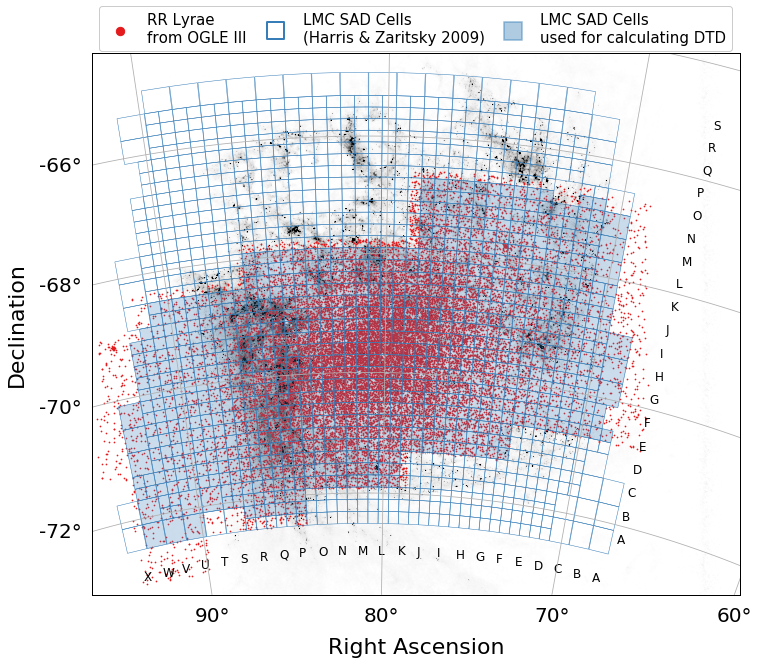

In [6]:
#~~~~~~~~ Knobs ~~~~~~~~~~~~~~~~~#
show_SFH_cellCentroids = False
show_cellLabels = False #Under construction
show_SFHCells = True #Careful - executing this takes a long time!
save_Plot = True
show_OGLEFields = False
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

from astropy.wcs import WCS 
#Tutorial on how to use wcsAxes for plotting = http://docs.astropy.org/en/stable/wcs/
#And for adjusting ticks = http://docs.astropy.org/en/stable/visualization/wcsaxes/ticks_labels_grid.html
colors = {'sfh':'#377eb8', 'rrlyrae':'#e41a1c'}

filename = get_pkg_data_filename(DTDpath + 'InputFiles/LMC60.M0NHC.FITS')
hdu = fits.open(filename)[0]
wcs = WCS(hdu.header)
pix_RRL = wcs.wcs_world2pix(15.0*np.asarray(objListRA), np.asarray(objListDec),1)
pix_cellCent = wcs.wcs_world2pix(cellCentersRA[cellInSurvey], cellCentersDec[cellInSurvey], 1)

#Separating 24'x24' cells from 12'x12' cells
names = np.asarray(cellNames)

lenelements = np.array([len(c) for c in names[cellInSurvey]])
cellsRA_12x12 = cellCentersRA[cellInSurvey][lenelements==5.]
cellsDec_12x12 = cellCentersDec[cellInSurvey][lenelements==5.]
cellsRA_24x24 = cellCentersRA[cellInSurvey][lenelements==2.]
cellsDec_24x24 = cellCentersDec[cellInSurvey][lenelements==2.]

lenelements_full = np.array([len(c) for c in names])
cellsRA_full_12x12 = cellCentersRA[lenelements_full==5.]
cellsDec_full_12x12 = cellCentersDec[lenelements_full==5.]
cellsRA_full_24x24 = cellCentersRA[lenelements_full==2.]
cellsDec_full_24x24 = cellCentersDec[lenelements_full==2.]

fig = plt.figure(figsize = [9., 9.])
fig.add_axes([0., 0., 1., 1.], projection=wcs)
ax = plt.gca()
ax.set_autoscale_on(False)
ax.scatter(pix_RRL[0], pix_RRL[1], edgecolor=colors['rrlyrae'], marker='.', s=2)
ax.imshow(hdu.data, origin='lower', aspect='equal', cmap='Greys', vmin=1.0e19, vmax=1.0e22)

sfh_letters_col = list('ABCDEFGHIJKLMNOPQRSTUVWX')
sfh_letters_row = sfh_letters_col[:-5]
letters_ra = np.array(0.5*(raKey[:,1][::2]+raKey[:,1][1::2]))
letters_dec = np.array(0.5*(decKey[28][::2]+decKey[28][1::2]))
token_dec = -73.
token_ra = 67.
for ra, let in zip(letters_ra, sfh_letters_col):
    ax.text(ra, token_dec, let, fontsize=12, transform=ax.get_transform('icrs'))
    
for dec, let in zip(letters_dec, sfh_letters_row):
    ax.text(token_ra, dec, let, fontsize=12, transform=ax.get_transform('icrs'))

#OGLE SURVEY FIELDS
if show_OGLEFields:
    ogle3fields_ascii = ascii.read(DTDpath+'RRLyrae_OGLE/OGLEIII_Fields.txt')
    ogle3fields_dec = Angle(ogle3fields['Dec'].data, unit='deg').degree
    ogle3fields_ra = Angle(ogle3fields['R.A.'].data, unit='hour').degree
    print 'Creating OGLE Fields...'
    ax.scatter(ogle3fields_ra, ogle3fields_dec, marker='o', color='green', \
               transform=ax.get_transform('icrs'))
    for ra_cen, dec_cen in zip(ogle3fields_ra, ogle3fields_dec):
        rect = Rectangle((ra_cen-0.85, dec_cen-0.3), width=1.7, height=0.6, facecolor='none', edgecolor='k',\
                        transform=ax.get_transform('icrs'))
        ax.add_patch(rect)


if show_SFHCells:
    print 'Creating 24x24 cells inside survey...'
    for ra_cen, dec_cen in zip(cellsRA_24x24, cellsDec_24x24):
        rect = Rectangle((ra_cen-0.55, dec_cen-0.2), width=1.1, height=0.4, lw=0.5, color=colors['sfh'],alpha=0.26,\
                         transform=ax.get_transform('icrs'))
        ax.add_patch(rect)

    print 'Creating 12x12 cells inside survey...'
    for ra_cen, dec_cen in zip(cellsRA_12x12, cellsDec_12x12):
        rect = Rectangle((ra_cen-0.275, dec_cen-0.1), width=0.55, height=0.2, lw=0.5, color=colors['sfh'],alpha=0.26,\
                         transform=ax.get_transform('icrs'))
        ax.add_patch(rect)

    print 'Creating 24x24 cells, all survey...'
    for ra_cen, dec_cen in zip(cellsRA_full_24x24, cellsDec_full_24x24):
        rect = Rectangle((ra_cen-0.55, dec_cen-0.2), width=1.1, height=0.4, lw=0.5, facecolor='none',edgecolor=colors['sfh'],\
                          transform=ax.get_transform('icrs'))
        ax.add_patch(rect)

    print 'Creating 12x12 cells, all survey...'
    for ra_cen, dec_cen in zip(cellsRA_full_12x12, cellsDec_full_12x12):
        rect = Rectangle((ra_cen-0.275, dec_cen-0.1), width=0.55, height=0.2, lw=0.5, facecolor='none',edgecolor=colors['sfh'],\
                         transform=ax.get_transform('icrs'))
        ax.add_patch(rect)

#ax.coords[0].set_major_formatter('hh:mm')
if show_SFH_cellCentroids:
    ax.scatter(cellCentersRA, cellCentersDec, marker='.', color=colors['sfh'], \
               transform=ax.get_transform('icrs'))
    ax.scatter(cellCentersRA[cellInSurvey], cellCentersDec[cellInSurvey], marker='.', color='green', \
               transform=ax.get_transform('icrs'))

[i.set_linewidth(5.0) for i in ax.spines.itervalues()]
ax.coords.grid()#Set this, otherwise the default is to use degrees
ax.coords[0].set_ticklabel(size=20)
ax.coords[0].set_axislabel('Right Ascension', fontsize=22)
ax.coords[1].set_ticklabel(size=20)
ax.coords[1].set_axislabel('Declination', fontsize=22)

ax.scatter([],[],marker='o', s=70, facecolor=colors['rrlyrae'], edgecolor=colors['rrlyrae'], label='RR Lyrae\nfrom OGLE III')
ax.scatter([],[],marker='s', s=300.0, lw=2.0, facecolor='none', edgecolor=colors['sfh'], \
           label='LMC SAD Cells\n(Harris & Zaritsky 2009)')
ax.scatter([],[],marker='s', s=300.0, lw=2.0, facecolor=colors['sfh'], edgecolor=colors['sfh'], \
           alpha=0.4, label='LMC SAD Cells\nused for calculating DTD')
ax.set_xlim(100,2050)  #Set limits are in units of pixels, unlike other functions where you can 
ax.set_ylim(270,1900)
#plt.tight_layout()
plt.legend(loc=2, bbox_to_anchor=(0.0, 1.0, 1.0, 0.1), mode='expand', framealpha=1.0, ncol=3, fontsize=15)
if save_Plot:
    plt.savefig(Plotpath + 'LMC_RRLyrae_Map_Figure1.png', bbox_inches='tight', dpi=100)
    plt.savefig(Plotpath + 'LMC_RRLyrae_Map_Figure1.pdf', bbox_inches='tight', dpi=100)
plt.show()